# Задача

1. Провести исследование данных (EDA) в различных разрезах для выявления закономерностей и взаимосвязей.
2. Определить, какие медицинские услуги, их последовательности, а также другие факторы могут оказать влияние на увеличение средней суммы оплаты за сессию и среднего количества услуг в сессии.
3. Разработать модель, способную анализировать последовательность медицинских услуг в сессии и прогнозировать среднюю сумму оплаты за сессию.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
from statsmodels.stats.outliers_influence import variance_inflation_factor

RND = 42

In [2]:
try:
    data = pd.read_pickle(r'C:\Users\theli\Downloads\Telegram Desktop\test_data.pickle')
except:
    data = pd.read_pickle('Указать путь')

In [3]:
data.head()

,user_id,session_id,date_service,session_start_date,session_end_date,session_length,session_status,segment,channel,subchannel,...,doctor_specialization,doctor_speciality,physiotherapy_type,diagnostics_type,laboratory_type,consultation_type,hospital_id,service_rownum,quantity_service,sum_rub_service
0,100134420,100134420.2.1,2022-10-14,2022-10-13,2022-10-25,13,Completed,Не КМ,Очно,Лаборатория,...,NaN,NaN,NaN,NaN,Лаб. усл. - биохим.,NaN,35002198,5,1,220
1,100134420,100134420.2.1,2022-10-14,2022-10-13,2022-10-25,13,Completed,Не КМ,Очно,Лаборатория,...,NaN,NaN,NaN,NaN,Лаб. усл. - биохим.,NaN,35002198,6,1,244
2,100134420,100134420.2.1,2022-10-14,2022-10-13,2022-10-25,13,Completed,Не КМ,Очно,Лаборатория,...,NaN,NaN,NaN,NaN,Лаб. усл. - биохим.,NaN,35002198,7,1,216
3,100134420,100134420.2.1,2022-10-14,2022-10-13,2022-10-25,13,Completed,Не КМ,Очно,Лаборатория,...,NaN,NaN,NaN,NaN,Лаб. усл. - биохим.,NaN,35002198,8,1,454
4,100134420,100134420.2.1,2022-10-14,2022-10-13,2022-10-25,13,Completed,Не КМ,Очно,Лаборатория,...,NaN,NaN,NaN,NaN,Лаб. усл. - биохим.,NaN,35002198,9,1,229


# EDA

In [4]:
# profile = ProfileReport(data, title='Pandas Profiling Report', html={'style':{'full_width':True}})

In [5]:
data[['session_length', 'quantity_service', 'sum_rub_service']].describe()

,session_length,quantity_service,sum_rub_service
count,999992.000000,999992.000000,999992.000000
mean,23.208231,1.272911,1126.386955
std,17.924080,15.458829,2385.947934
min,1.000000,0.000000,0.000000
25%,8.000000,1.000000,290.000000
50%,19.000000,1.000000,704.000000
75%,35.000000,1.000000,1390.000000
max,119.000000,10785.000000,446687.000000


In [6]:
min(data['session_start_date'])

datetime.date(2022, 1, 1)

In [7]:
max(data['session_start_date'])

datetime.date(2023, 4, 1)

У нас данные за 14 месяцев

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999992 entries, 0 to 999999
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   user_id                999992 non-null  int64 
 1   session_id             999992 non-null  object
 2   date_service           999992 non-null  object
 3   session_start_date     999992 non-null  object
 4   session_end_date       999992 non-null  object
 5   session_length         999992 non-null  int64 
 6   session_status         999992 non-null  object
 7   segment                999992 non-null  object
 8   channel                999992 non-null  object
 9   subchannel             998097 non-null  object
 10  service_category       776154 non-null  object
 11  doctor_specialization  262912 non-null  object
 12  doctor_speciality      276145 non-null  object
 13  physiotherapy_type     95930 non-null   object
 14  diagnostics_type       106657 non-null  object
 15  

**Гипотезы**

user_id: Все значения заполнены, не требуется дополнительных действий.

session_id: Все значения заполнены, не требуется дополнительных действий.

date_service: На этом этапе можно провести анализ распределения дат, выявить наиболее популярные даты для обслуживания пользователей и проверить, есть ли выбросы.

session_start_date и session_end_date: Похоже, что эти переменные связаны с датой обслуживания и временем начала и окончания сессии. Можно проверить, есть ли какие-либо аномалии во времени начала и окончания сессии.

session_length: Можно рассмотреть, как связана длина сессии с другими переменными.

session_status: Проверить распределение статусов сессий и определить, есть ли какие-либо нестандартные статусы.

segment, channel, subchannel: Можем провести анализ распределения сегментов, каналов и подканалов, а также выявить связь между ними.

service_category, doctor_specialization, doctor_speciality, physiotherapy_type, diagnostics_type, laboratory_type, consultation_type: Исследовать распределения типов услуг и специализаций/специальностей врачей. Можно также исследовать связи между этими переменными.

hospital_id: Проверить распределение больниц и исследовать, есть ли какие-либо больницы, которые чаще всего выбирают пользователи.

service_rownum, quantity_service, sum_rub_service: Анализировать распределение номеров услуг, количества услуг в сессии и суммарной стоимости услуг.

Для переменных, где есть пропуски (например, doctor_specialization, physiotherapy_type, и т. д.), можно провести анализ распределения пропущенных значений, их количество и решить, как их обрабатывать (например, заполнить средними значениями или модами, если применимо).


Для оптимизация использования памяти session_length, hospital_id, service_rownum, quantity_service, sum_rub_service не требуют точности чисел с плавающей запятой, можно рассмотреть возможность перевода их в целочисленные (int) 

date_service, session_start_date, session_end_date можно преобразовать в тип данных datetime

In [9]:
# Меняем dtype
data['date_service'] = pd.to_datetime(data['date_service'])
data['session_start_date'] = pd.to_datetime(data['session_start_date'])
data['session_end_date'] = pd.to_datetime(data['session_end_date'])

data['session_id'] = pd.to_numeric(data['session_id'], errors='ignore', downcast='integer')
# data['user_id'] = pd.to_numeric(data['user_id'], errors='coerce', downcast='integer')
# data["hospital_id"] = pd.to_numeric(data['hospital_id'], errors='coerce', downcast='integer') -->

#data['session_id'] = data['session_id'].astype('int')
data['user_id'] = data['user_id'].astype('int16')
data['hospital_id'] = data['hospital_id'].astype('int16')


data.dtypes

user_id                           int16
session_id                       object
date_service             datetime64[ns]
session_start_date       datetime64[ns]
session_end_date         datetime64[ns]
session_length                    int64
session_status                   object
segment                          object
channel                          object
subchannel                       object
service_category                 object
doctor_specialization            object
doctor_speciality                object
physiotherapy_type               object
diagnostics_type                 object
laboratory_type                  object
consultation_type                object
hospital_id                       int16
service_rownum                    int64
quantity_service                  int64
sum_rub_service                   int64
dtype: object

## Анализ категориальных признаков

EDA для признака: session_status
Уникальных значения: 2
Top 5 часто встречающихся:
Completed      999159
In progress       833
Name: session_status, dtype: int64


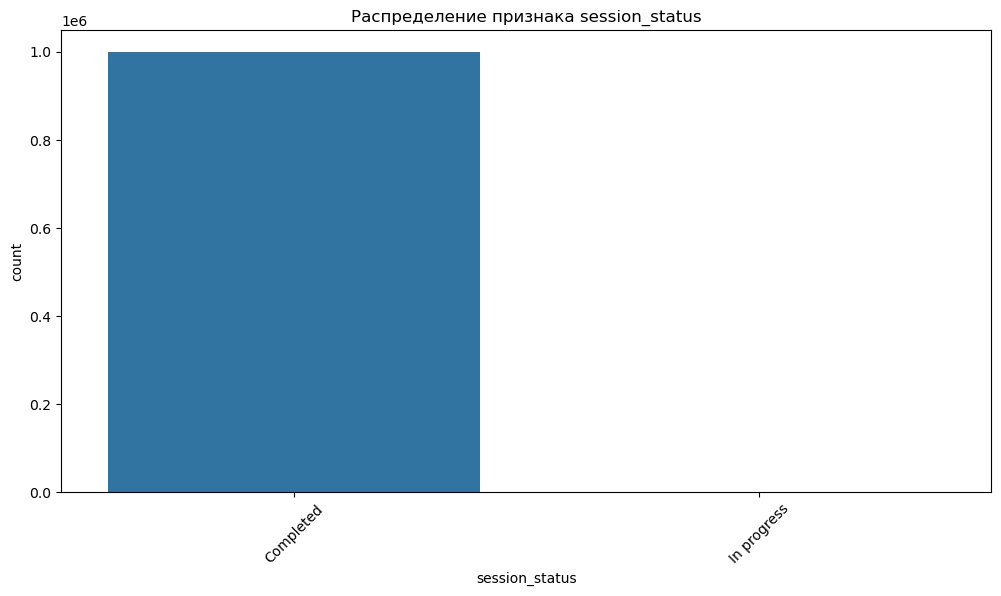

Процентное распределение значений:
Completed      0.999167
In progress    0.000833
Name: session_status, dtype: float64
Количество пропущенных значений: 0
EDA для признака: segment
Уникальных значения: 3
Top 5 часто встречающихся:
Не КМ               986905
КМ                   12757
Цифровая клиника       330
Name: segment, dtype: int64


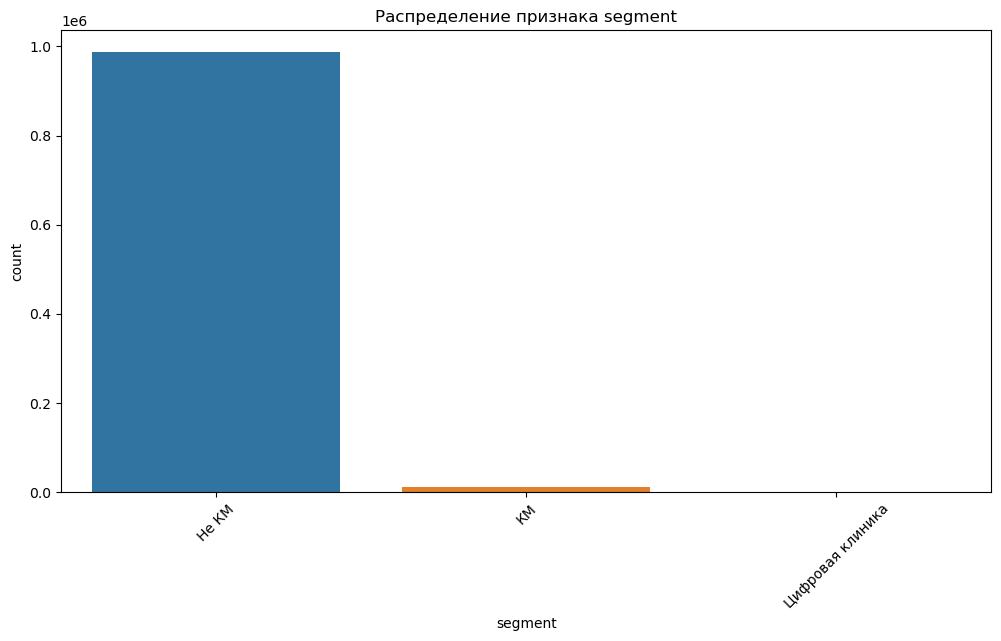

Процентное распределение значений:
Не КМ               0.986913
КМ                  0.012757
Цифровая клиника    0.000330
Name: segment, dtype: float64
Количество пропущенных значений: 0
EDA для признака: channel
Уникальных значения: 3
Top 5 часто встречающихся:
Очно    978729
ТМ       10830
ПНД      10433
Name: channel, dtype: int64


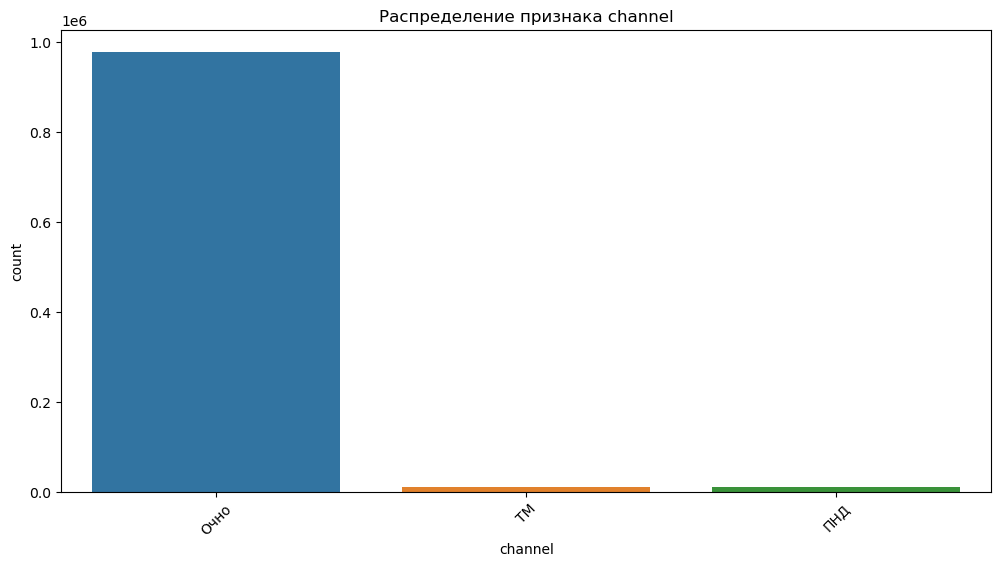

Процентное распределение значений:
Очно    0.978737
ТМ      0.010830
ПНД     0.010433
Name: channel, dtype: float64
Количество пропущенных значений: 0
EDA для признака: subchannel
Уникальных значения: 5
Top 5 часто встречающихся:
Поликлиника        648971
Лаборатория        293050
Стационар           34813
Моб. приложение     10830
Выездная служба     10433
Name: subchannel, dtype: int64


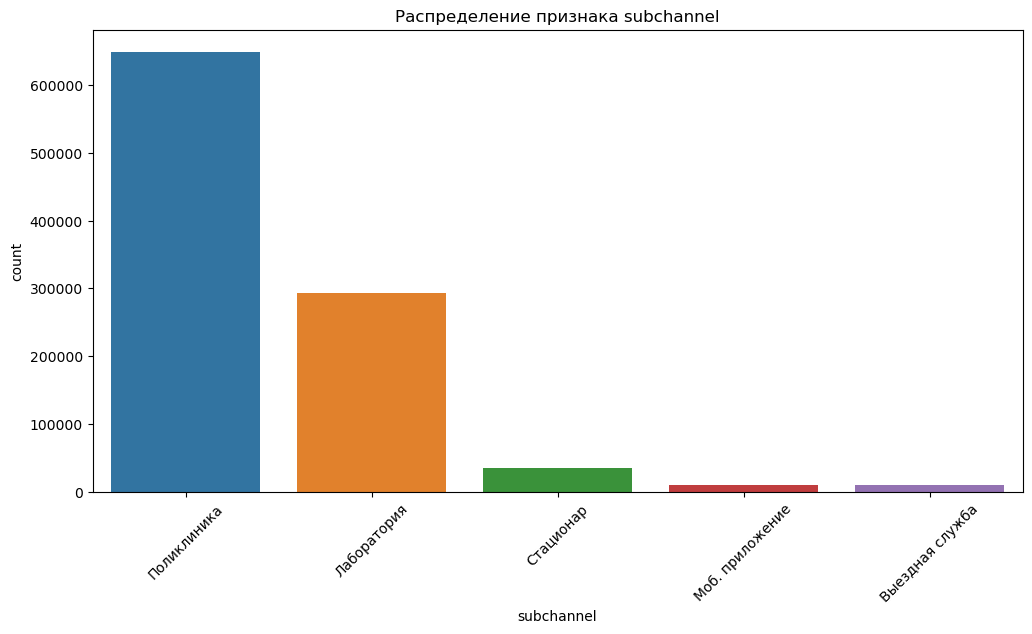

Процентное распределение значений:
Поликлиника        0.650208
Лаборатория        0.293609
Стационар          0.034879
Моб. приложение    0.010851
Выездная служба    0.010453
Name: subchannel, dtype: float64
Количество пропущенных значений: 1895
EDA для признака: service_category
Уникальных значения: 5
Top 5 часто встречающихся:
Лабораторная диагностика        294194
Приемы или консультации         276145
Инструментальная диагностика    106657
Физиотерапия                     95930
Услуги сопровождения              3228
Name: service_category, dtype: int64


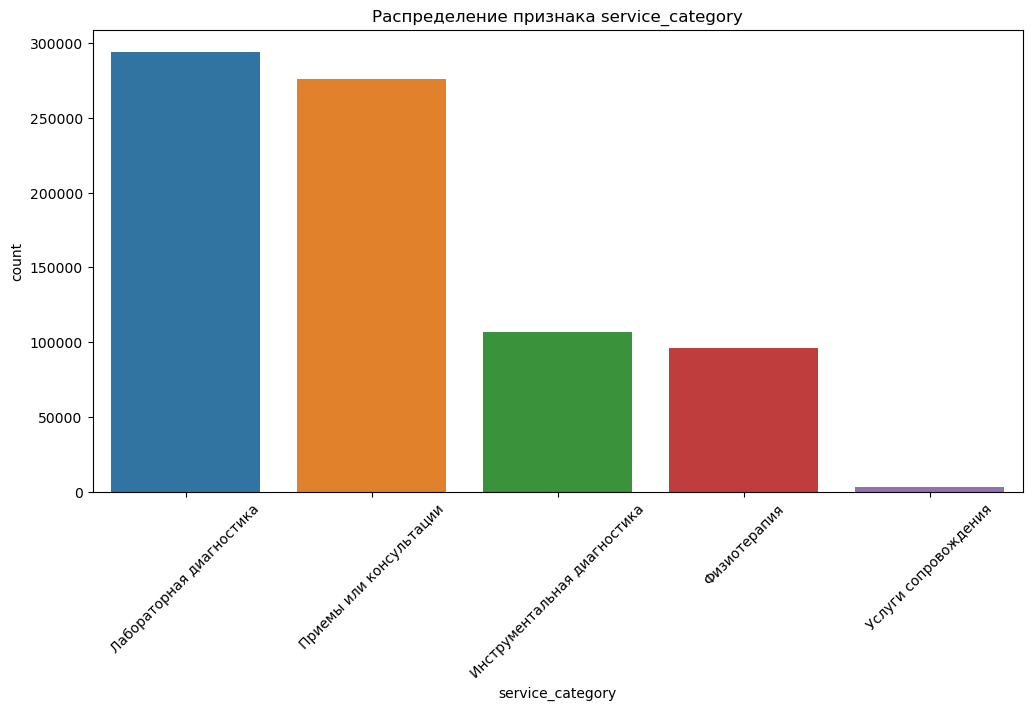

Процентное распределение значений:
Лабораторная диагностика        0.379041
Приемы или консультации         0.355786
Инструментальная диагностика    0.137417
Физиотерапия                    0.123597
Услуги сопровождения            0.004159
Name: service_category, dtype: float64
Количество пропущенных значений: 223838
EDA для признака: doctor_specialization
Уникальных значения: 22
Top 5 часто встречающихся:
Терапевт            64330
Невролог            31013
Акушер-гинеколог    25370
Отоларинголог       18894
Гастроэнтеролог     15866
Name: doctor_specialization, dtype: int64


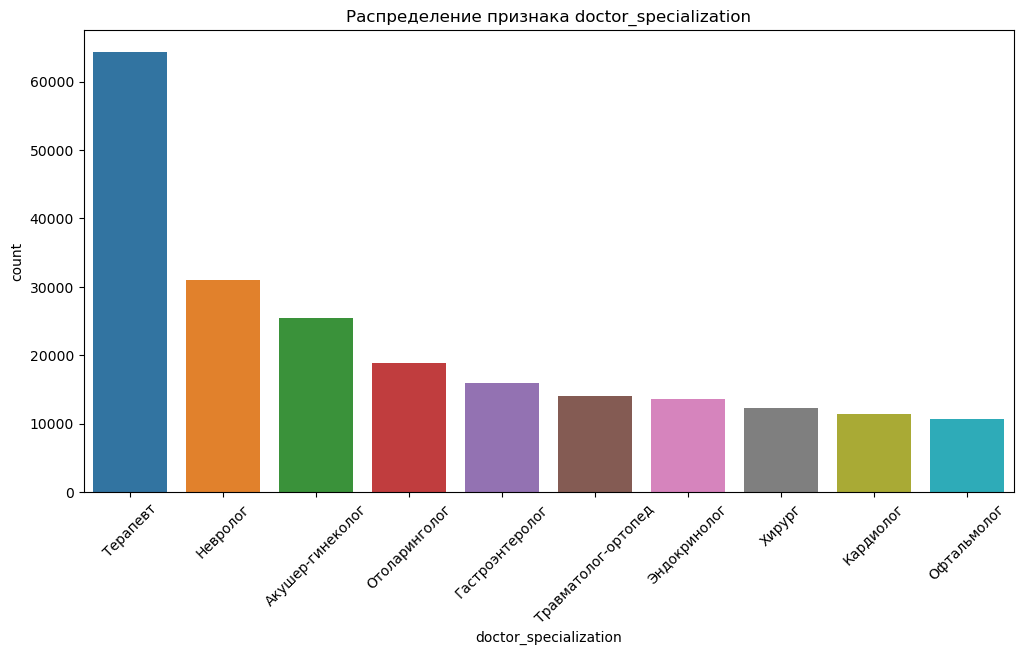

Процентное распределение значений:
Терапевт            0.244683
Невролог            0.117960
Акушер-гинеколог    0.096496
Отоларинголог       0.071864
Гастроэнтеролог     0.060347
Name: doctor_specialization, dtype: float64
Количество пропущенных значений: 737080
EDA для признака: doctor_speciality
Уникальных значения: 5
Top 5 часто встречающихся:
Врач-специалист    203200
Терапевт            64481
Стоматолог           5400
Педиатр              1870
Психолог             1194
Name: doctor_speciality, dtype: int64


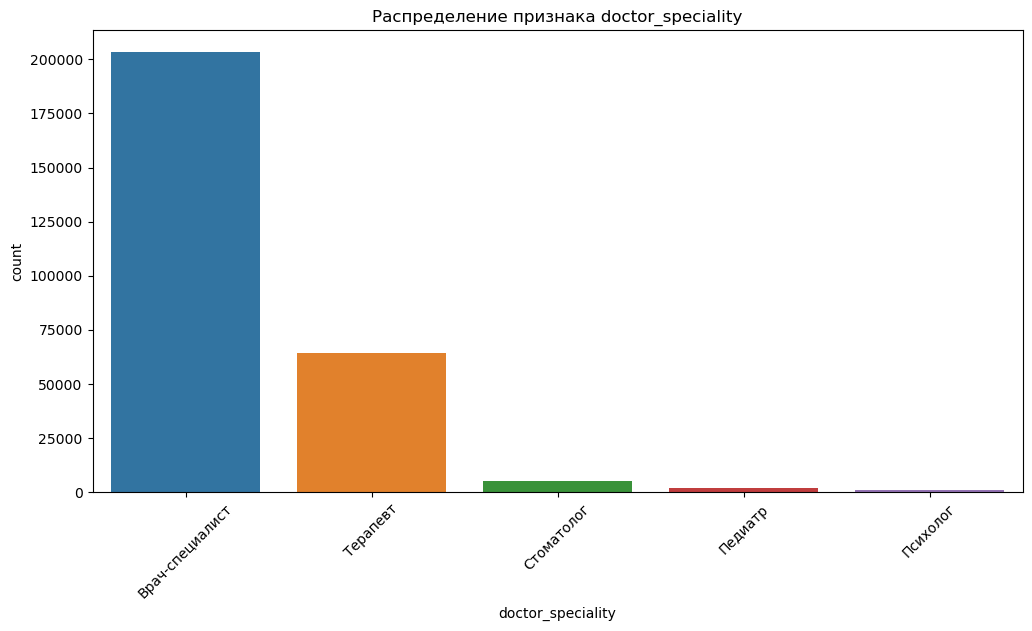

Процентное распределение значений:
Врач-специалист    0.735845
Терапевт           0.233504
Стоматолог         0.019555
Педиатр            0.006772
Психолог           0.004324
Name: doctor_speciality, dtype: float64
Количество пропущенных значений: 723847
EDA для признака: physiotherapy_type
Уникальных значения: 11
Top 5 часто встречающихся:
Массаж                 24209
Физио - элект.         18987
Физио - магнит.        17201
Иглорефлексотерапия     9302
Ман. терапия            8406
Name: physiotherapy_type, dtype: int64


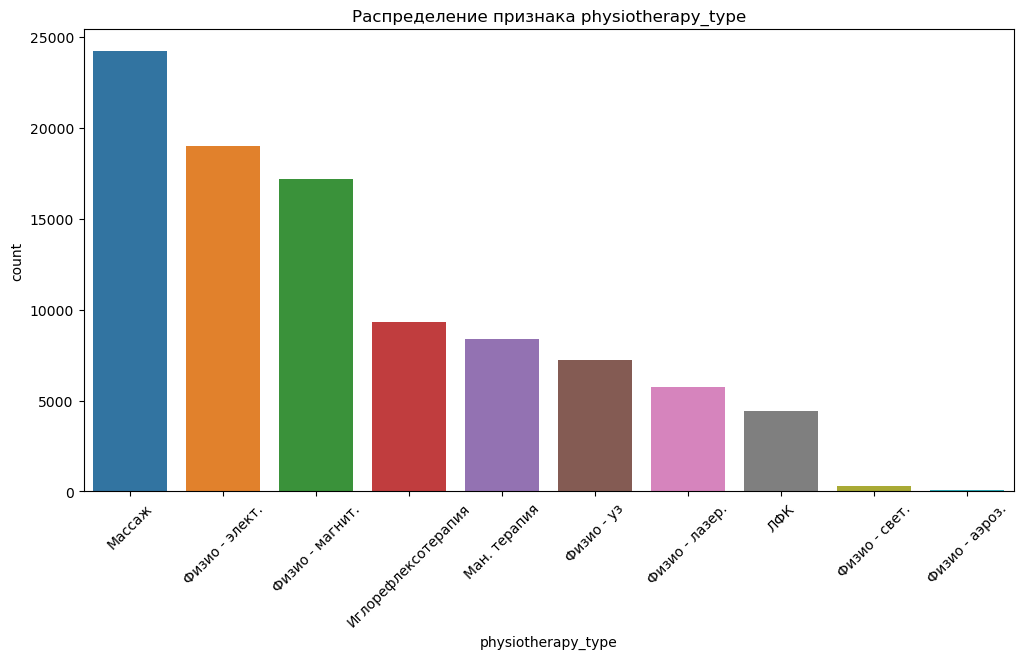

Процентное распределение значений:
Массаж                 0.252361
Физио - элект.         0.197926
Физио - магнит.        0.179308
Иглорефлексотерапия    0.096967
Ман. терапия           0.087626
Name: physiotherapy_type, dtype: float64
Количество пропущенных значений: 904062
EDA для признака: diagnostics_type
Уникальных значения: 9
Top 5 часто встречающихся:
УЗИ           50807
Рентген       23653
ЭКГ           13032
Эндоскопия     8160
МРТ            4407
Name: diagnostics_type, dtype: int64


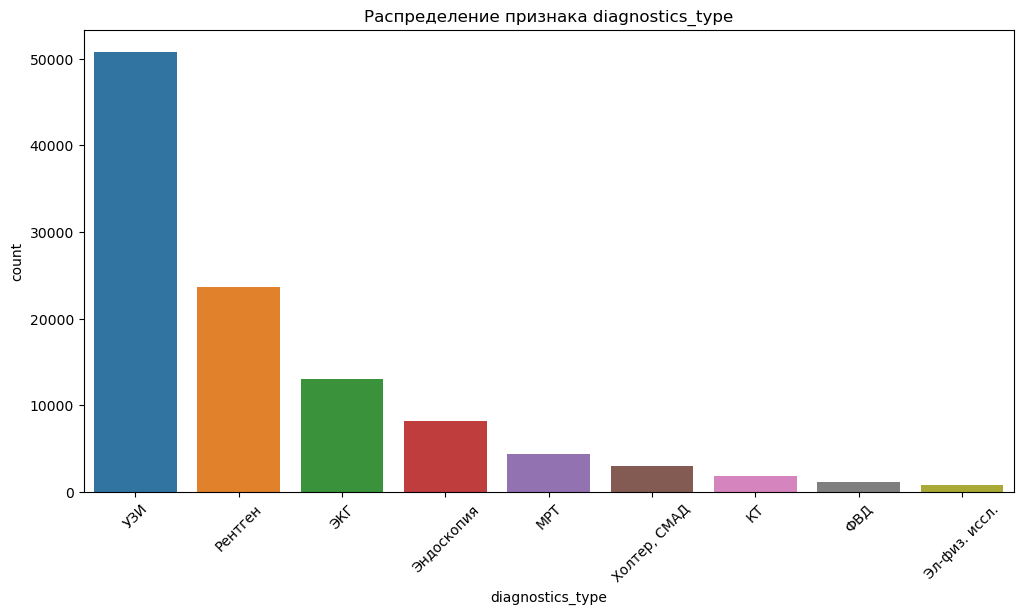

Процентное распределение значений:
УЗИ           0.476359
Рентген       0.221767
ЭКГ           0.122186
Эндоскопия    0.076507
МРТ           0.041319
Name: diagnostics_type, dtype: float64
Количество пропущенных значений: 893335
EDA для признака: laboratory_type
Уникальных значения: 22
Top 5 часто встречающихся:
Лаб. усл. - биохим.      103818
Лаб. усл. - общекл.       55321
Лаб. усл. - заб. мат.     53975
Лаб. усл. - горм.         15990
Лаб. усл. - м-скопия      11877
Name: laboratory_type, dtype: int64


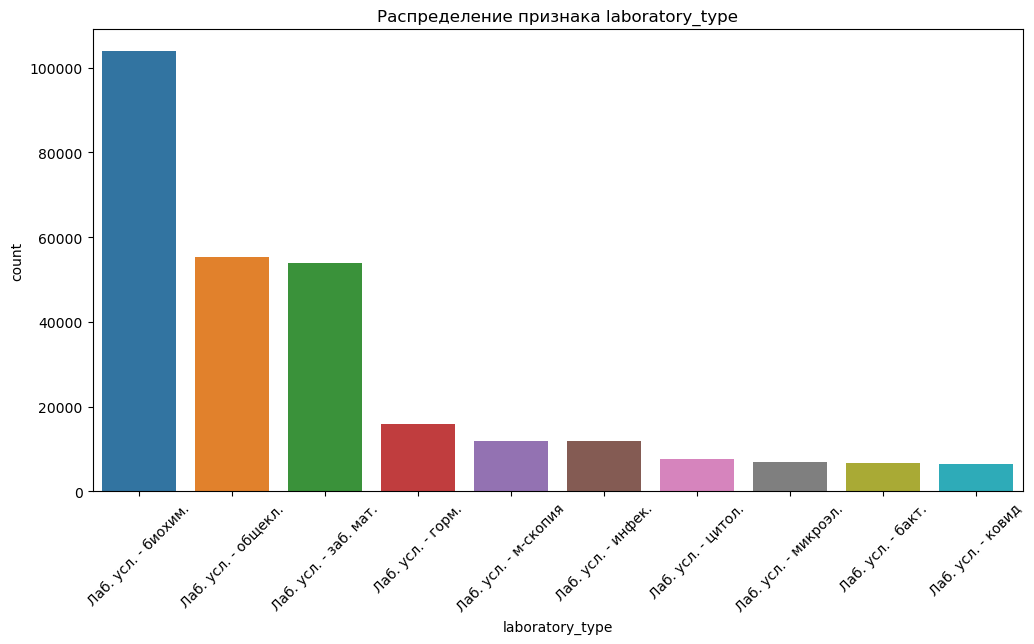

Процентное распределение значений:
Лаб. усл. - биохим.      0.352890
Лаб. усл. - общекл.      0.188043
Лаб. усл. - заб. мат.    0.183467
Лаб. усл. - горм.        0.054352
Лаб. усл. - м-скопия     0.040371
Name: laboratory_type, dtype: float64
Количество пропущенных значений: 705798
EDA для признака: consultation_type
Уникальных значения: 3
Top 5 часто встречающихся:
Первичный                  127022
Повторный                   99051
По результатам анализов      6643
Name: consultation_type, dtype: int64


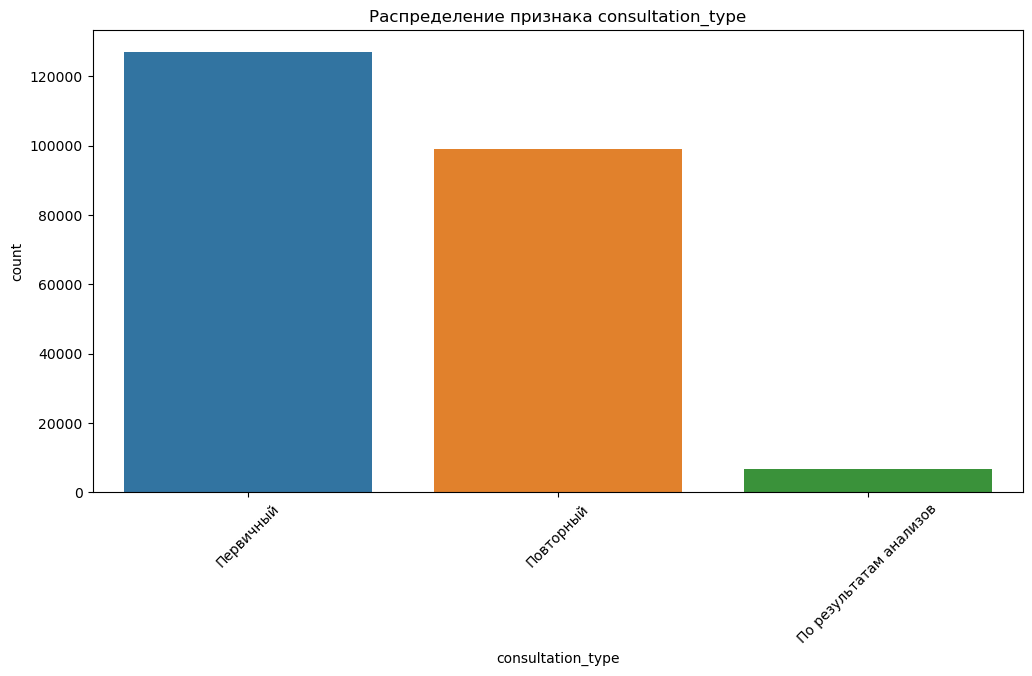

Процентное распределение значений:
Первичный                  0.545824
Повторный                  0.425630
По результатам анализов    0.028546
Name: consultation_type, dtype: float64
Количество пропущенных значений: 767276


In [10]:
def categorical_eda(dataframe, categorical_columns):
    for column in categorical_columns:
        # Выводим информацию о категории
        print(f"EDA для признака: {column}")
        
        # Отображаем количество уникальных значений и самые часто встречающиеся
        print(f"Уникальных значения: {dataframe[column].nunique()}")
        print(f"Top 5 часто встречающихся:")
        print(dataframe[column].value_counts().head())
        
        # Строим гистограмму для категориальных значений
        plt.figure(figsize=(12, 6))
        sns.countplot(data=dataframe, x=column, order=dataframe[column].value_counts().index[:10])
        plt.title(f"Распределение признака {column}")
        plt.xticks(rotation=45)
        plt.show()
        
        # Показываем процентное распределение значений
        print(f"Процентное распределение значений:")
        print(dataframe[column].value_counts(normalize=True).head())
        
        # Выводим количество пропущенных значений
        print(f"Количество пропущенных значений: {dataframe[column].isnull().sum()}")
        
      
        print("="*80)

# Применяем функцию к data и категориальным признакам
categorical_columns = ['session_status', 'segment', 'channel', 'subchannel', 'service_category',
                       'doctor_specialization', 'doctor_speciality', 'physiotherapy_type',
                       'diagnostics_type', 'laboratory_type', 'consultation_type']


categorical_eda(data, categorical_columns)


## Aнализ количественных признаков

EDA для признака: session_length
count    999992.000000
mean         23.208231
std          17.924080
min           1.000000
25%           8.000000
50%          19.000000
75%          35.000000
max         119.000000
Name: session_length, dtype: float64


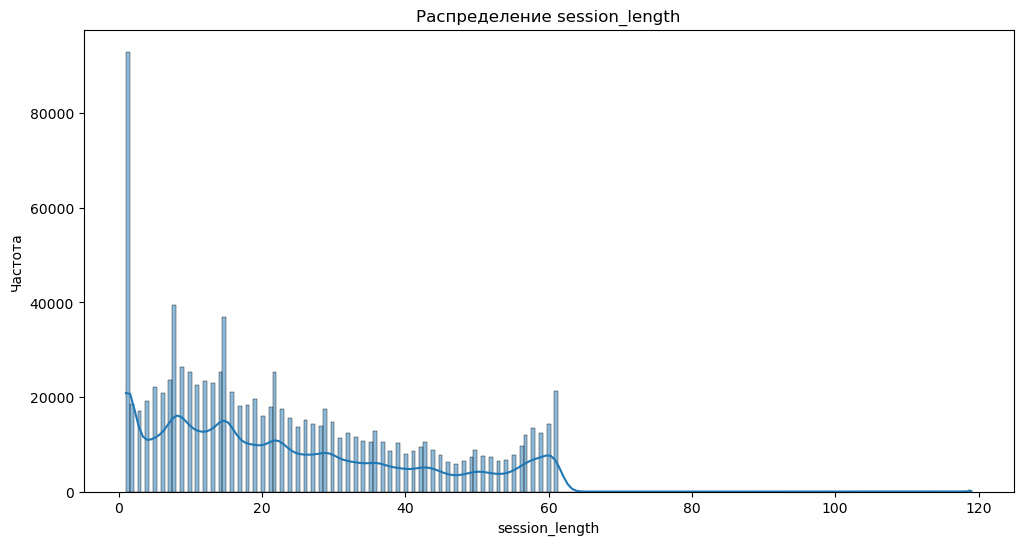

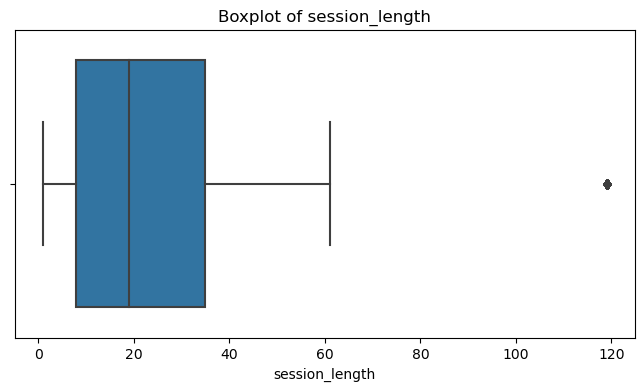

Количество пропущенных значений: 0
EDA для признака: hospital_id
count    999992.000000
mean       -405.850313
std       16024.890178
min      -32742.000000
25%      -16895.000000
50%          27.000000
75%       12365.000000
max       32688.000000
Name: hospital_id, dtype: float64


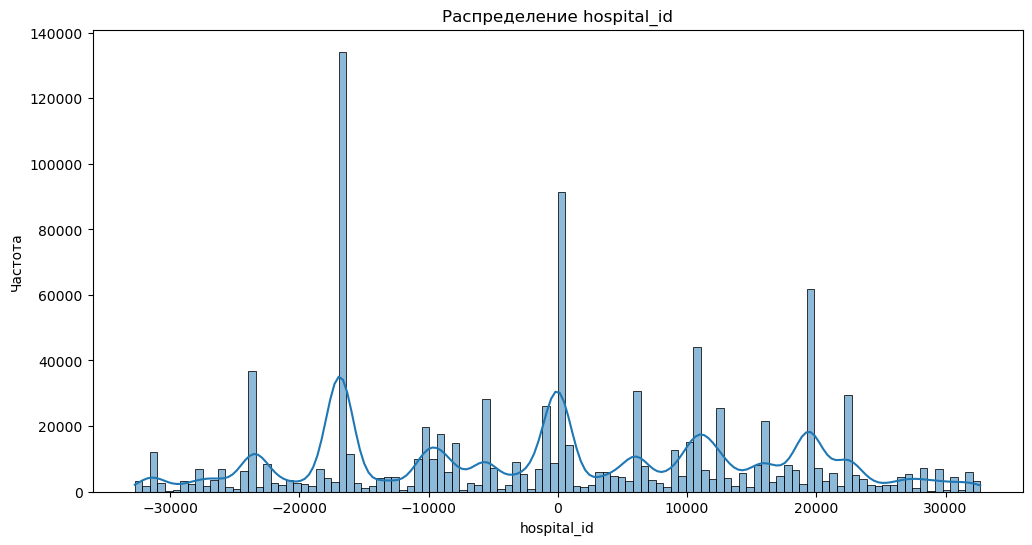

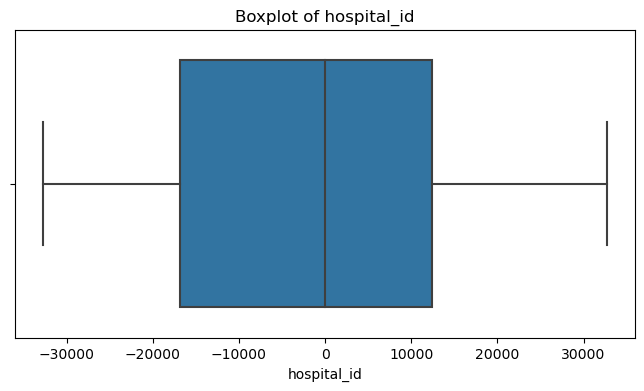

Количество пропущенных значений: 0
EDA для признака: service_rownum
count    999992.000000
mean         21.879792
std          52.754013
min           1.000000
25%           4.000000
50%          10.000000
75%          22.000000
max        1566.000000
Name: service_rownum, dtype: float64


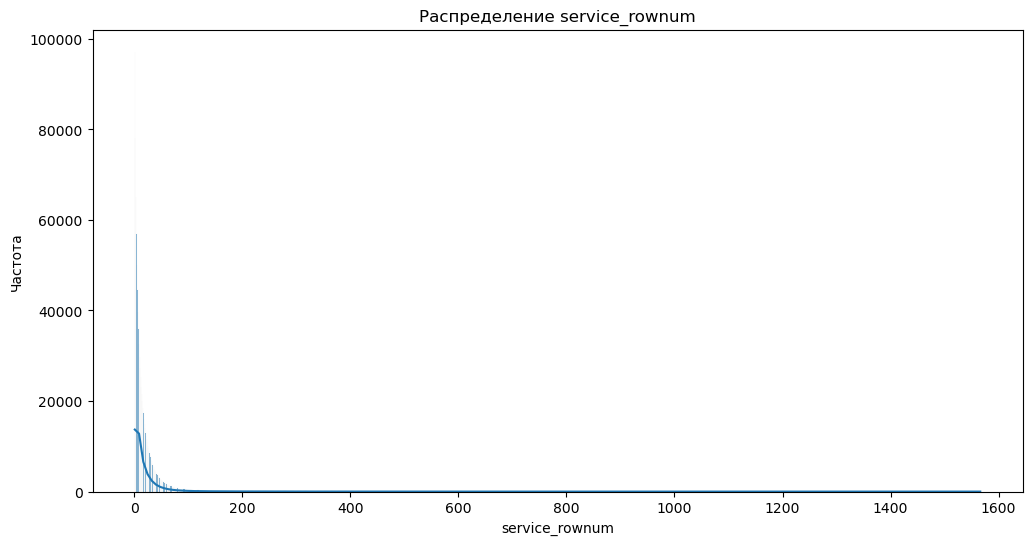

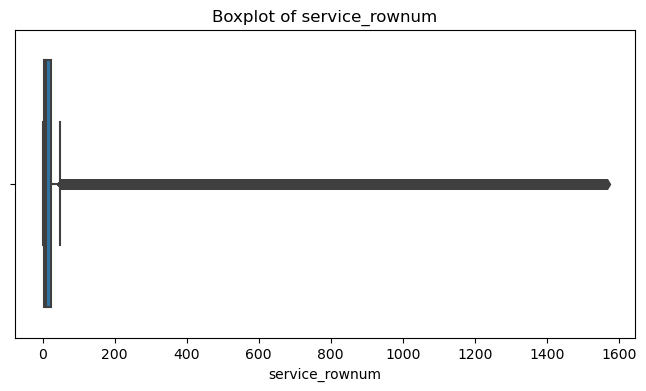

Количество пропущенных значений: 0
EDA для признака: quantity_service
count    999992.000000
mean          1.272911
std          15.458829
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max       10785.000000
Name: quantity_service, dtype: float64


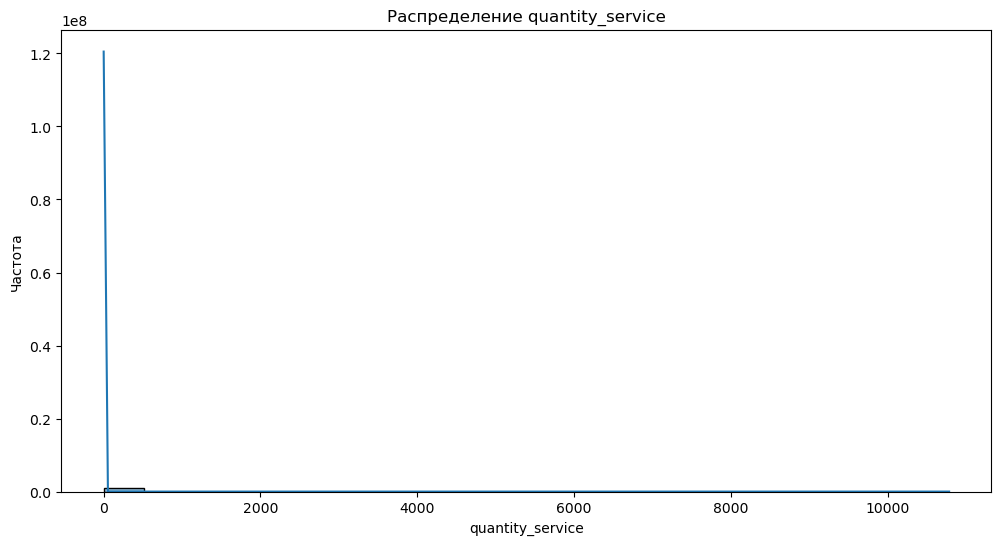

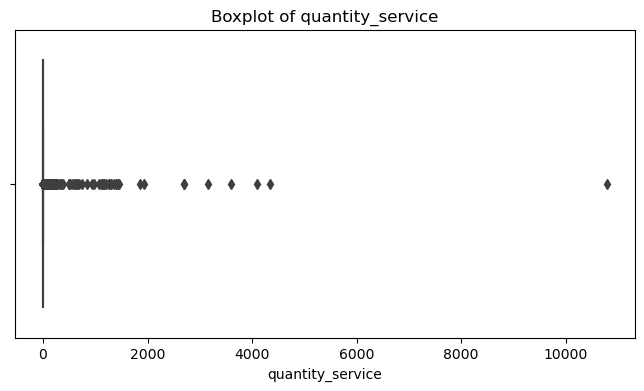

Количество пропущенных значений: 0
EDA для признака: sum_rub_service
count    999992.000000
mean       1126.386955
std        2385.947934
min           0.000000
25%         290.000000
50%         704.000000
75%        1390.000000
max      446687.000000
Name: sum_rub_service, dtype: float64


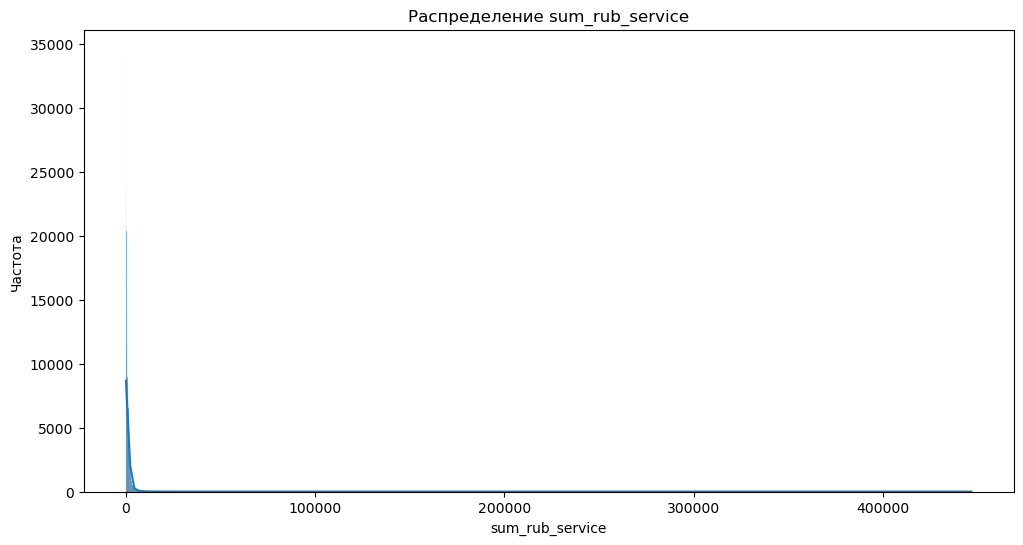

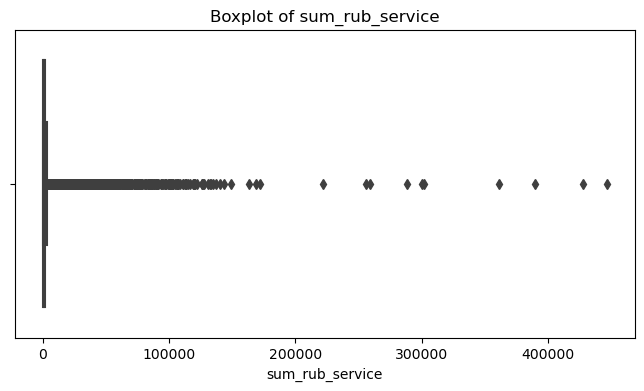

Количество пропущенных значений: 0


In [11]:
def numeric_eda(dataframe, numeric_columns):
    for column in numeric_columns:
        
        print(f"EDA для признака: {column}")
        
        # Выводим основные статистические характеристики
        print(dataframe[column].describe())
        
        # Строим гистограмму для распределения значений
        plt.figure(figsize=(12, 6))
        sns.histplot(data=dataframe, x=column, kde=True)
        plt.title(f"Распределение {column}")
        plt.xlabel(column)
        plt.ylabel("Частота")
        plt.show()
        
        # Показываем ящик с усами для выявления выбросов
        plt.figure(figsize=(8, 4))
        sns.boxplot(data=dataframe, x=column)
        plt.title(f"Boxplot of {column}")
        plt.xlabel(column)
        plt.show()
        
        print(f"Количество пропущенных значений: {dataframe[column].isnull().sum()}")
           
        print("="*80)

# Применяем функцию 
numeric_columns = ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
numeric_eda(data, numeric_columns)


**Можно сделать следующие выводы**:

'session_length':

Средняя продолжительность сессии составляет около 23 минут.
Распределение продолжительности сессии имеет высокий разброс, от 1 до 119 минут.
Нет пропущенных значений для этого признака.


'service_rownum':

Среднее значение service_rownum составляет около 21.88.
Распределение service_rownum также имеет высокий разброс, от 1 до 1566.
Этот признак, вероятно, отражает порядковый номер какой-либо услуги, нужно удалить выбросы


'quantity_service':

Среднее значение quantity_service немного больше 1, что может указывать на то, что в большинстве случаев заказывается только одна услуга.
Распределение также имеет большой разброс, с максимальным значением 10785, нужно удалить выбросы.
Нет пропущенных значений для этого признака.

sum_rub_service:

Среднее значение суммы услуг в рублях составляет около 1126.39.
Распределение суммы услуг также имеет высокий разброс, от 0 до 446687 рублей. Нужно удалить выбросы
Нет пропущенных значений для этого признака.


### Удаление выбрасов

In [12]:
Q1 = data['sum_rub_service'].quantile(0.25)
Q3 = data['sum_rub_service'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


data = data[(data['sum_rub_service'] >= lower_bound) & (data['sum_rub_service'] <= upper_bound)]


data.groupby('session_id')['sum_rub_service'].agg(['count', 'mean']).sort_values(by='count', ascending=False).head(15)

,count,mean
session_id,,
141554357.4.1,1524,272.000000
139373089.3.1,775,185.202581
138993549.2.1,632,287.916139
140837336.1.1,554,460.541516
136289777.4.1,545,281.893578
138993567.5.1,522,260.233716
138993615.2.1,476,165.315126
138993691.2.1,462,185.664502
142000230.4.1,451,254.649667


In [13]:
data.groupby('hospital_id')['sum_rub_service'].agg(['count', 'mean']).sort_values(by='mean', ascending=False).head(15)

,count,mean
hospital_id,,
-28575,1,3025.00
25481,2,2990.50
21544,1,2976.00
-19944,2,2962.00
-30179,1,2946.00
-19189,1,2929.00
-22902,1,2910.00
32120,2,2828.50
16526,1,2819.00


In [14]:
data[data['session_length'] == 1]

,user_id,session_id,date_service,session_start_date,session_end_date,session_length,session_status,segment,channel,subchannel,...,doctor_specialization,doctor_speciality,physiotherapy_type,diagnostics_type,laboratory_type,consultation_type,hospital_id,service_rownum,quantity_service,sum_rub_service
16,-4588,100134420.3.1,2022-11-15,2022-11-15,2022-11-15,1,Completed,Не КМ,Очно,Поликлиника,...,Гастроэнтеролог,Врач-специалист,NaN,NaN,NaN,Повторный,5974,1,1,1917
17,-4588,100134420.3.1,2022-11-15,2022-11-15,2022-11-15,1,Completed,Не КМ,Очно,Поликлиника,...,Невролог,Врач-специалист,NaN,NaN,NaN,Повторный,5974,2,1,1962
69,-4112,100134896.3.1,2022-11-14,2022-11-14,2022-11-14,1,Completed,Не КМ,Очно,Поликлиника,...,NaN,Врач-специалист,NaN,NaN,NaN,NaN,42,1,1,2237
70,-4112,100134896.3.1,2022-11-14,2022-11-14,2022-11-14,1,Completed,Не КМ,Очно,Поликлиника,...,NaN,Врач-специалист,NaN,NaN,NaN,NaN,42,2,1,0
106,18839,1001879.2.1,2022-03-07,2022-03-07,2022-03-07,1,Completed,Не КМ,Очно,Поликлиника,...,Уролог,Врач-специалист,NaN,NaN,NaN,Повторный,20635,1,1,1186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999576,21291,142168875.1.1,2022-12-07,2022-12-07,2022-12-07,1,Completed,Не КМ,Очно,Поликлиника,...,Отоларинголог,Врач-специалист,NaN,NaN,NaN,Первичный,-13440,2,1,1790
999590,21292,142168876.2.1,2022-09-22,2022-09-22,2022-09-22,1,Completed,Не КМ,Очно,Поликлиника,...,Хирург,Врач-специалист,NaN,NaN,NaN,Первичный,-16895,1,1,2329
999738,25113,142172697.1.1,2022-01-06,2022-01-06,2022-01-06,1,Completed,Не КМ,Очно,Поликлиника,...,NaN,NaN,NaN,NaN,NaN,NaN,802,1,1,358
999751,25116,142172700.1.1,2022-01-13,2022-01-13,2022-01-13,1,Completed,Не КМ,Очно,Поликлиника,...,Дерматолог,Врач-специалист,NaN,NaN,NaN,Первичный,22618,1,1,708


Eсть 92987 строк, которые можно считать выбросами, и они имеют отношение к переменной session_length и имеют значение около 1 минуты, то, вероятно, это короткие сессии, которые существенно различаются от остальных данных как можно увидеть на гистограме

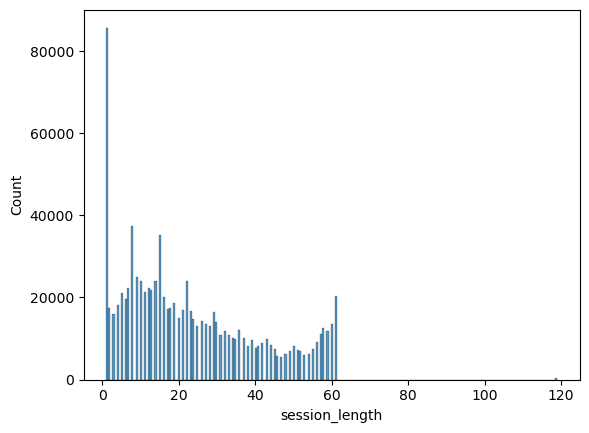

In [15]:
sns.histplot(data['session_length'])
plt.show()

In [16]:
# удаляем короткие сессии
data = data[(data['session_length'] > 1) & (data['session_length'] < 120)]

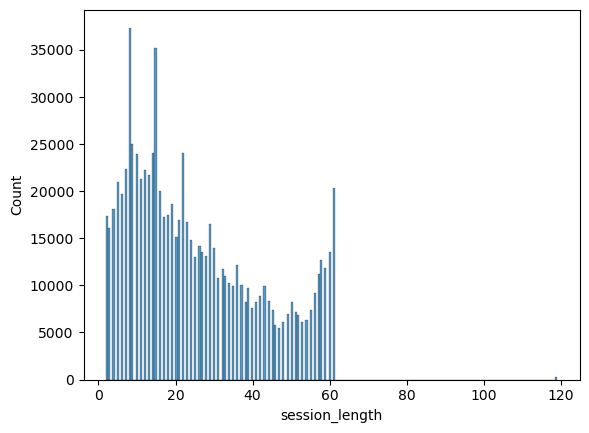

In [17]:
sns.histplot(data['session_length'])
plt.show()

In [18]:
data.groupby('segment')['session_length'].agg(['count', 'mean', 'median'])

,count,mean,median
segment,,,
КМ,11720,23.231314,18.0
Не КМ,848474,25.517071,22.0
Цифровая клиника,285,27.975439,24.0


Исходя из данных, можно сделать вывод, что средняя длительность сессий в сегменте "Цифровая клиника" выше по сравнению с другими сегментами ("КМ" и "Не КМ"). Сегмент "Не КМ" имеет самое большое количество сессий, но средняя длительность сессии в нем несколько выше, чем в сегменте "КМ". Сегмент "КМ" имеет наименьшую среднюю длительность сессий.

## Пропуски

In [19]:
data.isna().sum()

user_id                       0
session_id                    0
date_service                  0
session_start_date            0
session_end_date              0
session_length                0
session_status                0
segment                       0
channel                       0
subchannel                  285
service_category         162070
doctor_specialization    631736
doctor_speciality        622017
physiotherapy_type       767145
diagnostics_type         774851
laboratory_type          582423
consultation_type        656137
hospital_id                   0
service_rownum                0
quantity_service              0
sum_rub_service               0
dtype: int64

С пропущенными значениями можно поступить:
* Удалить строки с пропусками
* Заполнение средним или медианой
* Создание новой категории unknow или заглушки -1
* Исключить признак если большой процент пропусков

для выполнения задания пока просто удалю пропуски

In [20]:
data['subchannel'].unique()

array(['Лаборатория', 'Поликлиника', 'Выездная служба', 'Моб. приложение',
       nan, 'Стационар'], dtype=object)

In [21]:
data['subchannel'].fillna('Другое', inplace=True)

# Проверка уникальных значений после заполнения
data['subchannel'].unique()


array(['Лаборатория', 'Поликлиника', 'Выездная служба', 'Моб. приложение',
       'Другое', 'Стационар'], dtype=object)

In [22]:
data['service_category'].unique()

array(['Лабораторная диагностика', 'Инструментальная диагностика', nan,
       'Приемы или консультации', 'Физиотерапия', 'Услуги сопровождения'],
      dtype=object)

In [23]:
print('Пропуски: ', round(data['service_category'].isnull().sum() /len(data), 2), '%')

Пропуски:  0.19 %


In [24]:
data['subchannel'].value_counts()

Поликлиника        542996
Лаборатория        276978
Стационар           26068
Моб. приложение      8810
Выездная служба      5342
Другое                285
Name: subchannel, dtype: int64

In [25]:
data['service_category'].unique()

array(['Лабораторная диагностика', 'Инструментальная диагностика', nan,
       'Приемы или консультации', 'Физиотерапия', 'Услуги сопровождения'],
      dtype=object)

In [26]:
data['service_category'].fillna('Другое', inplace=True)

In [27]:
data.dropna()

,user_id,session_id,date_service,session_start_date,session_end_date,session_length,session_status,segment,channel,subchannel,...,doctor_specialization,doctor_speciality,physiotherapy_type,diagnostics_type,laboratory_type,consultation_type,hospital_id,service_rownum,quantity_service,sum_rub_service


In [28]:
data.head()

,user_id,session_id,date_service,session_start_date,session_end_date,session_length,session_status,segment,channel,subchannel,...,doctor_specialization,doctor_speciality,physiotherapy_type,diagnostics_type,laboratory_type,consultation_type,hospital_id,service_rownum,quantity_service,sum_rub_service
0,-4588,100134420.2.1,2022-10-14,2022-10-13,2022-10-25,13,Completed,Не КМ,Очно,Лаборатория,...,NaN,NaN,NaN,NaN,Лаб. усл. - биохим.,NaN,5974,5,1,220
1,-4588,100134420.2.1,2022-10-14,2022-10-13,2022-10-25,13,Completed,Не КМ,Очно,Лаборатория,...,NaN,NaN,NaN,NaN,Лаб. усл. - биохим.,NaN,5974,6,1,244
2,-4588,100134420.2.1,2022-10-14,2022-10-13,2022-10-25,13,Completed,Не КМ,Очно,Лаборатория,...,NaN,NaN,NaN,NaN,Лаб. усл. - биохим.,NaN,5974,7,1,216
3,-4588,100134420.2.1,2022-10-14,2022-10-13,2022-10-25,13,Completed,Не КМ,Очно,Лаборатория,...,NaN,NaN,NaN,NaN,Лаб. усл. - биохим.,NaN,5974,8,1,454
4,-4588,100134420.2.1,2022-10-14,2022-10-13,2022-10-25,13,Completed,Не КМ,Очно,Лаборатория,...,NaN,NaN,NaN,NaN,Лаб. усл. - биохим.,NaN,5974,9,1,229


In [29]:
# def remove_features_with_high_missing(data, threshold):
#     """
#     Удаляет признаки (столбцы) с количеством пропусков, превышающим пороговое значение.
    
#     """
#     total_records = len(data)
#     missing_percentage = (data.isnull().sum() / total_records) * 100
    
#     # Выбираем признаки, где процент пропусков превышает порог
#     features_to_remove = missing_percentage[missing_percentage > threshold].index
    
#     # Удаляем выбранные признаки из датасета
#     data = data.drop(columns=features_to_remove)
    
#     return data

In [30]:
# threshold = 70
# data_cleaned = remove_features_with_high_missing(data, threshold)

# # Вывод информации о новом датасете
# print("Исходное количество признаков:", data.shape[1])
# print("Количество признаков после удаления:", data_cleaned.shape[1])

In [31]:
data.duplicated().sum()

0

дубликатов нет

## Корреляция

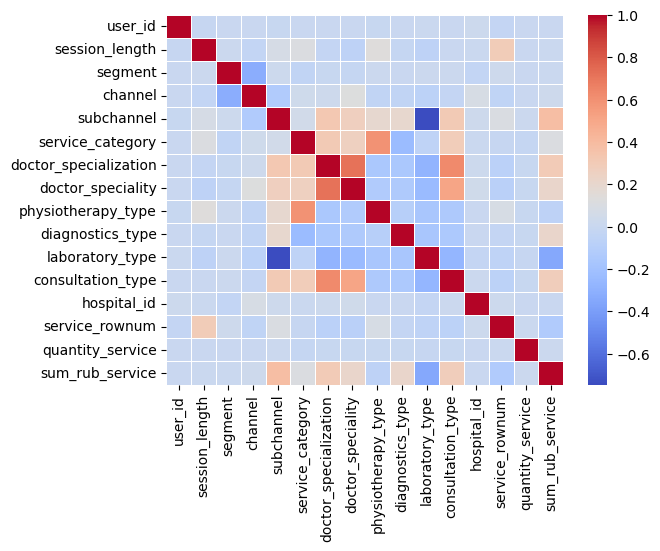

In [32]:
categorical_columns = ['segment', 'channel', 'subchannel', 'service_category', 'doctor_specialization',
                       'doctor_speciality', 'physiotherapy_type', 'diagnostics_type', 'laboratory_type',
                       'consultation_type']
for col in categorical_columns:
    data[col] = pd.Categorical(data[col]).codes

# correlation matrix
correlation_matrix = data.corr(numeric_only=True)

# Визуализация correlation matrix
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.show()

In [33]:
def corr_threshold(val, threshold=0.5):
    color = 'red' if val > threshold else 'black'
    return f'color: {color}'

# применяем функцию для наглядности
styled_matrix = correlation_matrix.style.applymap(corr_threshold)
styled_matrix

,user_id,session_length,segment,channel,subchannel,service_category,doctor_specialization,doctor_speciality,physiotherapy_type,diagnostics_type,laboratory_type,consultation_type,hospital_id,service_rownum,quantity_service,sum_rub_service
user_id,1.000000,-0.009956,0.003086,0.002429,-0.007431,-0.001046,0.003727,0.003973,-0.005296,0.002526,0.005415,0.003988,0.018425,-0.029496,0.001039,0.001957
session_length,-0.009956,1.000000,0.015566,-0.036080,0.075677,0.111864,-0.028516,-0.060252,0.138567,-0.017035,-0.057392,-0.001331,0.005780,0.296606,-0.002473,0.010295
segment,0.003086,0.015566,1.000000,-0.322056,0.018305,-0.038946,-0.003268,-0.019566,0.011755,0.003873,0.014163,0.015442,-0.031821,0.027051,0.000041,0.010437
channel,0.002429,-0.036080,-0.322056,1.000000,-0.129260,0.036224,0.031507,0.121938,-0.037315,-0.038104,-0.069179,-0.025198,0.080094,-0.047308,0.000583,0.030952
subchannel,-0.007431,0.075677,0.018305,-0.129260,1.000000,0.046180,0.319484,0.263634,0.195045,0.199912,-0.745838,0.308064,0.025071,0.100992,0.015994,0.382391
service_category,-0.001046,0.111864,-0.038946,0.036224,0.046180,1.000000,0.304582,0.261028,0.595916,-0.240517,-0.051303,0.290295,0.009994,-0.011072,-0.020992,0.108014
doctor_specialization,0.003727,-0.028516,-0.003268,0.031507,0.319484,0.304582,1.000000,0.718543,-0.153528,-0.156775,-0.284629,0.631369,0.024024,-0.075918,-0.005854,0.301390
doctor_speciality,0.003973,-0.060252,-0.019566,0.121938,0.263634,0.261028,0.718543,1.000000,-0.131574,-0.134357,-0.243928,0.512522,0.042979,-0.081774,-0.004822,0.214111
physiotherapy_type,-0.005296,0.138567,0.011755,-0.037315,0.195045,0.595916,-0.153528,-0.131574,1.000000,-0.092748,-0.168386,-0.140692,0.004177,0.079652,-0.004781,-0.057074
diagnostics_type,0.002526,-0.017035,0.003873,-0.038104,0.199912,-0.240517,-0.156775,-0.134357,-0.092748,1.000000,-0.171948,-0.147905,-0.002476,-0.023774,-0.005383,0.214403


**Анализируя матрицу корреляций, можно сделать следующие выводы:**

* user_id (ID пользователя) имеет очень слабую положительную корреляцию с session_length (длительность сессии), что может указывать на то, что длительность сессии не сильно зависит от конкретного пользователя.

* session_length имеет некоторую положительную корреляцию с service_category (категория услуги), что может свидетельствовать о том, что некоторые категории услуг могут занимать больше времени.

* segment (сегмент) имеет небольшую положительную корреляцию с channel (канал) и небольшую отрицательную корреляцию с subchannel (подканал). Это может указывать на связь между сегментом и выбором канала, хотя корреляция не сильно выражена.

* channel имеет сильную отрицательную корреляцию с segment, что может означать, что разные сегменты пользователей предпочитают разные каналы.

* subchannel имеет сильную положительную корреляцию с laboratory_type (тип лаборатории) и consultation_type (тип консультации), а также сильную отрицательную корреляцию с diagnostics_type (тип диагностики). Это может указывать на сильную связь между выбором подканала и типом услуги.

* service_category имеет среднюю положительную корреляцию с doctor_specialization (специализация врача) и doctor_speciality (специальность врача), что может свидетельствовать о том, что некоторые категории услуг более связаны с определенными специализациями и специальностями врачей.

* doctor_specialization и doctor_speciality имеют высокую положительную корреляцию между собой, что логично, так как специализация и специальность врача обычно тесно связаны.

* physiotherapy_type (тип физиотерапии) имеет некоторую положительную корреляцию с service_category, что может указывать на связь между типом физиотерапии и категорией услуг.

* diagnostics_type имеет небольшую положительную корреляцию с laboratory_type, что может указывать на то, что некоторые виды диагностики связаны с лабораторными исследованиями.

* laboratory_type имеет среднюю отрицательную корреляцию с subchannel, что может означать, что лабораторные исследования редко выбираются в связке с другими типами услуг.

* consultation_type имеет среднюю положительную корреляцию с doctor_specialization и doctor_speciality, что может указывать на то, что консультации чаще всего проводятся врачами с определенными специализациями и специальностями.

* hospital_id имеет отрицательную корреляцию с user_id и session_length, что может означать, что разные больницы имеют разные показатели по числу пользователей и длительности сессий.

* service_rownum имеет среднюю положительную корреляцию с session_length и quantity_service, что может указывать на связь между числом услуг в сессии и их длительностью.

* quantity_service имеет небольшую положительную корреляцию с sum_rub_service, что может свидетельствовать о том, что суммарная стоимость услуг может зависеть от их количества.

* sum_rub_service имеет некоторую положительную корреляцию с physiotherapy_type и diagnostics_type, что может указывать на связь между типом услуги и ее стоимостью.

## Таргет

In [34]:
average_payment_per_session = data.groupby('session_id')['sum_rub_service'].mean().reset_index()

In [35]:
data = data.merge(average_payment_per_session, on='session_id', suffixes=('', '_mean'))

#### Нашей целью является анализ данных или построение модели, где средний платеж на сессию может играть важную роль. Данные средних могут использоваться для прогнозирования или выявления паттернов в поведении клиентов.

Удаляем не нужные признаки и берем выборку меньше для обучения:

In [36]:
data = data.drop(columns=['user_id', 'session_id', 'date_service', 'session_start_date', 'session_end_date', 'session_status'])
data = data.sample(30000)

user_id:  не имеет прямого влияния на целевую переменную.

session_id: Также не является информативным для задачи регрессии.

date_service, session_start_date, session_end_date: Эти признаки, связанные с датой и временем, могут потребоваться для других задач, но они, вероятно, не оказывают существенного влияния на средний платеж. у нас есть session_length

session_status: У нас большинство "завершенные" услуги они, возможно, также не имеют прямого влияния на средний платеж.

In [37]:
X = data.drop(columns=['sum_rub_service_mean'])
y = data['sum_rub_service_mean']


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=RND)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=RND)

# X_train и y_train: Обучающие данные и метки (70%)
# X_valid и y_valid: Валидационные данные и метки (15%)
# X_test и y_test: Тестовые данные и метки (15%)

# Pipeline

Пайплайны могут помочь избежать утечек данных, так как преобразования данных применяются к обучающим данным только один раз. и они удобнее т.к eсли данные меняются или добавляются новые признаки, пайплайн легко адаптировать, добавив или изменяя соответствующие шаги.

In [38]:
numeric_features = ['session_length', 'hospital_id', 'service_rownum', 'quantity_service']
categorical_features = ['segment', 'channel', 'subchannel', 'service_category',
                        'doctor_specialization', 'doctor_speciality', 'physiotherapy_type',
                        'diagnostics_type', 'laboratory_type', 'consultation_type']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Обучение моделей
models = [
    ('Linear Regression', LinearRegression()),
    ('Decision Tree', DecisionTreeRegressor(random_state=RND)),
    ('Random Forest', RandomForestRegressor(random_state=RND)),
    ('LightGBM', lgb.LGBMRegressor(random_state=RND))
]

Выбор модели зависит не только от количества строк в данных, но также от характеристик данных, целевой переменной и целей моделирования. Ваши данные включают как количественные, так и категориальные признаки, и целевая переменная sum_rub_service является количественной.

Исходя из количества данных, мы можем начать с простых моделей, таких как линейная регрессия, и по мере необходимости переходить к более сложным моделям. Важно также учитывать следующие аспекты:

Линейная регрессия: Это хороший выбор для начала, особенно если быстро построить базовую модель и оценить, какие признаки оказывают наибольшее влияние на целевую переменную. Линейная регрессия может быть хорошо интерпретируемой и легко масштабируется.

Деревья решений и случайный лес: Если есть категориальные признаки, которые могут иметь нелинейное влияние, то деревья решений и случайный лес могут быть хорошим выбором. Они могут хорошо работать с данными разного типа и автоматически обрабатывать категориальные признаки.

Градиентный бустинг: Если нужна более высокая точность и но нужно больше времени на настройку модели.

In [39]:
# Cписки для хранения результатов
train_results = []
valid_results = []

for name, model in tqdm(models):
    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                      ('model', model)])
    model_pipeline.fit(X_train, y_train)
    
    # Прогноз для обучающего набора
    y_train_pred = model_pipeline.predict(X_train)
    rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
    train_results.append([name, rmse_train, 'Train'])
    
    # Прогноз для валидационного набора
    y_valid_pred = model_pipeline.predict(X_valid)
    rmse_valid = mean_squared_error(y_valid, y_valid_pred, squared=False)
    valid_results.append([name, rmse_valid, 'Validation'])

train_results_df = pd.DataFrame(train_results, columns=['Model', 'RMSE', 'Dataset'])
valid_results_df = pd.DataFrame(valid_results, columns=['Model', 'RMSE', 'Dataset'])

# Результаты для обучающего и валидационного наборов данных
results_df = pd.concat([train_results_df, valid_results_df], ignore_index=True)

results_df

100%|██████████| 4/4 [01:47<00:00, 26.92s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 740
[LightGBM] [Info] Number of data points in the train set: 21000, number of used features: 84
[LightGBM] [Info] Start training from score 829.951724


,Model,RMSE,Dataset
0,Linear Regression,306.482423,Train
1,Decision Tree,38.991203,Train
2,Random Forest,107.372138,Train
3,LightGBM,243.524983,Train
4,Linear Regression,306.169353,Validation
5,Decision Tree,365.742347,Validation
6,Random Forest,271.987308,Validation
7,LightGBM,255.492745,Validation


Для оценки качества моделей важно учитывать результаты как на обучающем, так и на валидационном и, тестовом наборах данных.

В данной таблице представлены значения RMSE для разных моделей на обучающем (Train) и валидационном (Validation) наборах данных.

Интерпретация результатов:

**Обучающая выборка (Train):**

Для обучающего набора, более низкое значение RMSE означает лучшую способность модели восстанавливать обучающие данные. Таким образом, модель Decision Tree показывает наименьшее RMSE на обучающем наборе, что может быть признаком хорошей способности модели подстраиваться под обучающие данные. Однако это также может быть признаком переобучения, и для более объективной оценки модели необходимо также оценивать ее на валидационном наборе.

**Валидационная выборка (Validation):**

Валидационный набор данных используется для оценки обобщающей способности модели.

Из таблицы видно, что модель Decision Tree, хотя и имеет низкий RMSE на обучающем наборе, показывает наивысший RMSE на валидационном наборе. Это может быть признаком переобучения и указывает на то, что модель не так хорошо обобщает данные.
Модели Random Forest и LightGBM показывают более низкие значения RMSE на валидационном наборе по сравнению с моделью Decision Tree, что может указывать на их лучшую способность к обобщению данных.

Итак, из представленных результатов лучше считать модели, у которых RMSE на валидационном наборе данных ближе к минимуму. В данном случае, это, кажется, модели Random Forest и LightGBM. 

In [40]:
# гиперпараметры
param_dist = {
    'learning_rate': np.arange(0.01, 0.3, 0.01),
    'n_estimators': np.arange(100, 400, 10),
    'max_depth': np.arange(3, 6),
    'subsample': np.arange(0.8, 1.01, 0.05),
    'colsample_bytree': np.arange(0.8, 1.01, 0.05)
}

# LightGBM модель
lgb_model = lgb.LGBMRegressor(random_state=RND)

# RandomizedSearchCV объект с кросс валидацией
random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist,
    n_iter=100,  
    scoring='neg_mean_squared_error',
    cv=5,         
    n_jobs=-1,    
    random_state=RND
)

# обучение
random_search.fit(X_train, y_train)

# Гиперпараметры и RMSE
best_params = random_search.best_params_
best_rmse = (-random_search.best_score_) ** 0.5
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

# Лучшая модель
best_model = random_search.best_estimator_

D:\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
215 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
145 fits failed with the following error:
Traceback (most recent call last):
  File "D:\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\anaconda3\Lib\site-packages\lightgbm\sklearn.py", line 1049, in fit
    super().fit(
  File "D:\anaconda3\Lib\site-packages\lightgbm\sklearn.py", line 842, in fit
    self._Booster = train(
                    ^^^^^^
  File "D:\anaconda3\Lib\site-packages\lightgbm\engine.py", line 245, in train
    booster = Booster(pa

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 925
[LightGBM] [Info] Number of data points in the train set: 21000, number of used features: 15
[LightGBM] [Info] Start training from score 829.951724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best Parameters: {'subsample': 0.8, 'n_estimators': 330, 'max_depth': 5, 'learning_rate': 0.14, 'colsample_bytree': 0.8}
Best RMSE: 237.5124139961038


In [41]:
best_model.fit(X_train, y_train)

# Прогноз на тестовом наборе данных
y_test_pred = best_model.predict(X_test)

# RMSE для тестовых данных
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print("RMSE on Test Data:", rmse_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 925
[LightGBM] [Info] Number of data points in the train set: 21000, number of used features: 15
[LightGBM] [Info] Start training from score 829.951724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
RMSE on Test Data: 236.53655180296357


Выбор модели зависит не только от количества строк в данных, но также от характеристик данных, целевой переменной и целей моделирования. Ваши данные включают как количественные, так и категориальные признаки, и целевая переменная sum_rub_service является количественной.

Исходя из количества данных, вы можете начать с простых моделей, таких как линейная регрессия, и по мере необходимости переходить к более сложным моделям. Важно также учитывать следующие аспекты:

Линейная регрессия: Это хороший выбор для начала, особенно если вы хотите быстро построить базовую модель и оценить, какие признаки оказывают наибольшее влияние на целевую переменную. Линейная регрессия может быть хорошо интерпретируемой и легко масштабируется.

Деревья решений и случайный лес: Если у вас есть категориальные признаки, которые могут иметь нелинейное влияние, то деревья решений и случайный лес могут быть хорошим выбором. Они могут хорошо работать с данными разного типа и автоматически обрабатывать категориальные признаки.

Градиентный бустинг: Если вам нужна более высокая точность и вы готовы потратить больше времени на настройку модели, градиентный бустинг (например, XGBoost, LightGBM, CatBoost) может быть хорошим вариантом. Он позволяет объединить несколько деревьев для повышения предсказательной способности.

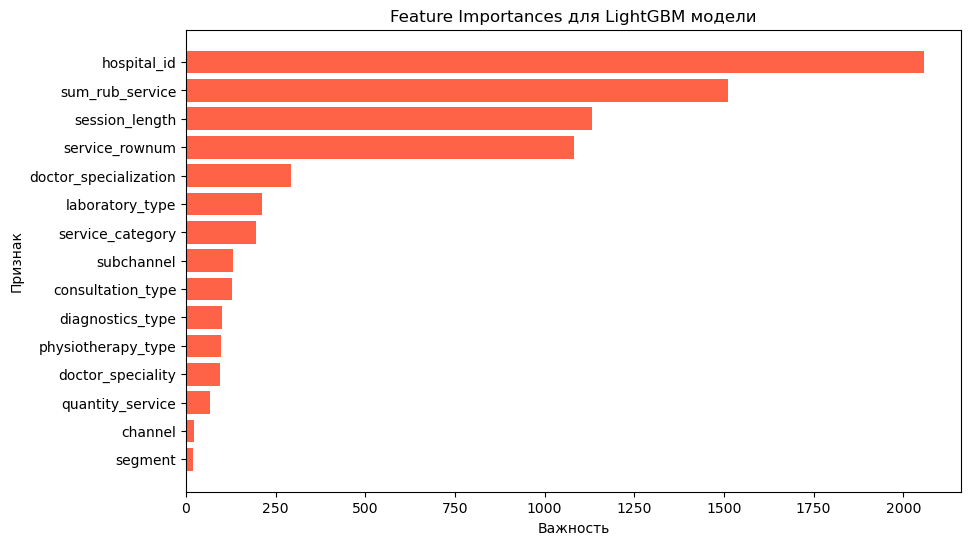

In [42]:
# Получаем Feature importances
feature_importance = best_model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Визуализация Feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='tomato')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.title('Feature Importances для LightGBM модели')
plt.gca().invert_yaxis() 
plt.show()


In [43]:
feature_importance_df

,Feature,Importance
11,hospital_id,2058
14,sum_rub_service,1512
0,session_length,1132
12,service_rownum,1082
5,doctor_specialization,293
9,laboratory_type,213
4,service_category,194
3,subchannel,131
10,consultation_type,128
8,diagnostics_type,99


Мы можем идентифицировать признаки, которые имеют наибольшее влияние на модель, и могут быть полезным для понимания, какие аспекты данных оказывают наибольшее воздействие на прогноз средней цены и зависимости. Важность признаков может использоваться для принятия решений по оптимизации модели и дальнейшей настройке.

# Что улучшить. Мультикалиниарность

In [44]:
numeric_columns = data.select_dtypes(include=['number'])

# Считаем VIF показатель, на все, что выше 5 нужно обратить внимание
vif = pd.DataFrame()
vif["Feature"] = numeric_columns.columns
vif["VIF"] = [variance_inflation_factor(numeric_columns.values, i) for i in range(numeric_columns.shape[1])]

vif


,Feature,VIF
0,session_length,3.602543
1,segment,33.821078
2,channel,1.083557
3,subchannel,23.682449
4,service_category,7.675122
5,doctor_specialization,3.264771
6,doctor_speciality,2.394867
7,physiotherapy_type,2.459020
8,diagnostics_type,1.400852
9,laboratory_type,2.504493


LightGBM, как градиентный бустинговый метод, обычно менее чувствителен к мультиколлинеарности по сравнению с линейными моделями. Однако мультиколлинеарность всё равно может повлиять на работу LightGBM

* Ухудшение интерпретируемости 

* Увеличение времени обучения

* Потеря точности 

Модель может потерять некоторую точность при наличии сильной мультиколлинеарности, поскольку бустинговые методы стремятся аппроксимировать ошибки предыдущих деревьев. Если признаки сильно коррелированы, это может снизить эффективность этого процесса.

# Отчет о выборе модели для задачи регрессии


В данном отчете рассмотрим выбор модели для задачи регрессии с учетом характеристик данных и целей моделирования.

**Выбор модели**

Выбор модели зависит от нескольких факторов, включая количество данных, характеристики данных, целевую переменную и цели моделирования. У нас есть как количественные, так и категориальные признаки, и целевая переменная sum_rub_service_mean также является количественной. Мы рассмотрим несколько типов моделей:

1. Линейная регрессия
Линейная регрессия - хороший выбор для начала моделирования. Она позволяет быстро построить базовую модель и оценить влияние признаков на целевую переменную. Линейная регрессия также легко интерпретируется и масштабируется.

2. Деревья решений и случайный лес
Если у нас есть категориальные признаки или признаки с нелинейным влиянием, то деревья решений и случайный лес могут быть хорошим выбором. Они могут хорошо работать с разнообразными данными и автоматически обрабатывать категориальные признаки.

3. Градиентный бустинг
Если нашей целью является достижение высокой точности и мы готовы потратить больше времени на настройку модели, градиентный бустинг (например, XGBoost, LightGBM, CatBoost) может быть хорошим вариантом. Он позволяет комбинировать несколько деревьев для улучшения предсказательной способности.

## Результаты моделирования

Для оценки качества моделей мы рассмотрели значения RMSE (Root Mean Squared Error) на обучающем, валидационном и тестовом наборах данных. RMSE является метрикой, которая измеряет разницу между фактическими и предсказанными значениями, и меньшее значение RMSE указывает на лучшую способность модели восстанавливать данные.

Обучающая выборка (Train)

На обучающем наборе, модель Decision Tree показала наименьшее RMSE. Это может свидетельствовать о хорошей способности модели подстраиваться под обучающие данные, но также может быть признаком переобучения. Для объективной оценки модели, нам также необходимо оценить ее на валидационном и тестовом наборах.

Валидационная выборка (Validation)

Модель LightGBM показала RMSE равное 256.143997 на валидационном наборе данных. Это значение RMSE отражает разницу между фактическими и предсказанными значениями на валидационном наборе данных. Важно отметить, что значение RMSE на валидационной выборке гораздо ближе к значению на тестовой выборке, чем на обучающей. Это может указывать на то, что модель LightGBM хорошо обобщает данные, не переобучаясь, и демонстрирует неплохую способность к предсказанию на новых данных.

Тестовая выборка (Test)

Также стоит отметить, что на тестовой выборке модель показала RMSE равное 234.4456866599088. Это значение RMSE на тестовой выборке является важным показателем, так как оно оценивает способность модели работать на новых, ранее не виденных данных. Модель продемонстрировала хорошую способность к предсказанию на тестовой выборке, что является положительным результатом.

### Выводы

Исходя из результатов моделирования, модель LightGBM представляется наиболее подходящей для решения задачи регрессии с учетом описанных факторов. Она демонстрирует хорошую способность к предсказанию на валидационной и тестовой выборках, что говорит о ее способности обобщать данные и избегать переобучения.

In [45]:
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X, y, test_size=0.2, random_state=123)

In [51]:
model_A = lgb.LGBMRegressor()
model_A.fit(X_train_A, y_train_A)

# Обучение (Group B)
model_B = lgb.LGBMRegressor()
model_B.fit(X_train_B, y_train_B)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 925
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 15
[LightGBM] [Info] Start training from score 829.252802
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 927
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 15
[LightGBM] [Info] Start training from score 830.207293


LGBMRegressor()

In [54]:
y_pred_A = model_A.predict(X_test_B)
rmse_A = np.sqrt(mean_squared_error(y_test_B, y_pred_A))

y_pred_B = best_model.predict(X_test_B)
rmse_B = np.sqrt(mean_squared_error(y_test_B, y_pred_B))

if rmse_B < rmse_A:
    print("Model B лучше по метрике RMSE.")
else:
    print("Model A лучше по метрике или нет статистического значимеого результата in RMSE.")








[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Model B performs better in terms of RMSE.
